In [1]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [2]:
%load_ext autoreload
%autoreload

In [3]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from scipy.stats import randint as sp_randint

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *
import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/feat_eng_abt_split.h5')
X_train = store['X_train']
X_test = store['X_test']
y_train = store['y_train']
y_test = store['y_test']
store.close()

# Drop msno from the dataset
X_train.drop(['msno'], inplace=True, axis=1)
X_test.drop(['msno'], inplace=True, axis=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

cat_col = ['gender', 'city', 'registered_via', 'payment_method_id_mode']

X_train.head()

(600803, 18) (600803,)
(257487, 18) (257487,)


,city,bd,gender,registered_via,registration_init_time,membership_months,total_order,payment_method_id_mode,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,actual_amount_mean,total_actual_amount,is_auto_renew_mode,cancel_times,transaction_date_delta
0,5,28,male,3,2013-12-23,38,6,31,2,0,10.00,49.67,298.00,149.00,894.00,True,1,700.00
1,13,20,male,3,2013-12-23,38,5,38,3,30,25.40,125.40,627.00,125.40,627.00,False,0,344.00
2,13,18,male,3,2013-12-27,38,18,38,1,30,30.00,149.00,2682.00,149.00,2682.00,False,0,530.00
3,1,0,unknown,7,2014-01-09,37,19,41,2,30,25.63,125.47,2384.00,141.16,2682.00,True,3,413.00
4,13,35,female,7,2014-01-25,37,24,41,1,30,26.25,105.38,2529.00,123.17,2956.00,True,2,586.00


In [5]:
import sklearn 
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [6]:
## WHAT METRIC SHOULD BE OPTIMSED AS PART OF CV

In [10]:
RANDOM_STATE = 42 
CV_ITER = 5
SCORING_METRIC = 'recall'
BASE_NAME = "random_" + str(CV_ITER) + "cv_" + SCORING_METRIC

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]

classifiers = [
        ('NB_' + BASE_NAME, GaussianNB(), {}, 
               SCORING_METRIC),    
        ('DT_' + BASE_NAME, DecisionTreeClassifier(), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                             "criterion": ["entropy"], 
                             "max_depth":sp_randint(10,30), 
                             "min_samples_leaf":sp_randint(10,50),
                             "min_samples_split":sp_randint(10,100),
                             "class_weight":[None, "balanced"],
                             "presort" : [True, False]}, 
                SCORING_METRIC),    
        ('RF_' + BASE_NAME, RandomForestClassifier(n_jobs =-1), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                             "criterion": ["entropy","gini"], 
                             "n_estimators": sp_randint(100,200),
                             "max_depth":sp_randint(10,30), 
                             "min_samples_leaf":sp_randint(10,50),
                             "min_samples_split":sp_randint(10,100),
                             "class_weight":[None, "balanced"]},
               SCORING_METRIC),    
        ('LR_' + BASE_NAME, LogisticRegression(), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                             "solver" : ['newton-cg', 'lbfgs', 'liblinear','saga'],
                             "class_weight": [None, "balanced"],
                             "max_iter": sp_randint(10,100),
                             "C": sp_randint(1,10)}, 
               SCORING_METRIC),
#         ('AB_' + BASE_NAME, AdaBoostClassifier(), 
#                         {'search_type': 'RANDOM_SEARCH_CV',
#                              "n_estimators": sp_randint(300,800),
#                         }, 
#                 SCORING_METRIC),
        ('MLP_' + BASE_NAME, MLPClassifier(), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                             "hidden_layer_sizes": [(50,), (100,)],
                             "activation": ["tanh", "relu"],
                             "solver": ["adam"],
                             "alpha": [0.0001, 0.001, 0.01]}, 
                SCORING_METRIC),
        ('XGB_' + BASE_NAME, xgb.XGBClassifier(objective="binary:logistic", n_jobs=8), 
                        {'search_type': 'RANDOM_SEARCH_CV',
                             "n_estimators": sp_randint(100,200),
                             "max_depth":sp_randint(1,6),
                             "learning_rate": [0.0001, 0.001, 0.01]
                             }, SCORING_METRIC) 
]

In [8]:
all_metrics = pd.DataFrame()
all_results = list()

### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (600803, 18) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 18) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
X_train:  (600803, 52) (600803, 1)
X_test:  (257487, 52) (257487, 1)


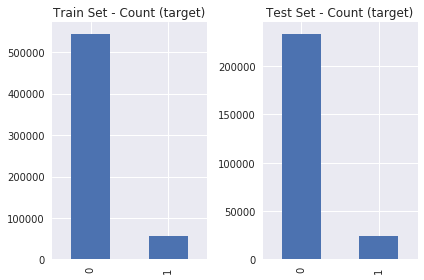

Training NB_random_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_random_5cv_recall classifier
Optimising using RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.1min finished


CLF: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 19, 'min_samples_split': 98, 'presort': True}
Generating test scores for DT_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training RF_random_5cv_recall classifier
Optimising using RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.6min finished


CLF: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 24, 'min_samples_split': 84, 'n_estimators': 180}
Generating test scores for RF_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training LR_random_5cv_recall classifier
Optimising using RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.8min finished


CLF: {'C': 7, 'class_weight': 'balanced', 'max_iter': 74, 'solver': 'liblinear'}
Generating test scores for LR_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training AB_random_5cv_recall classifier
Optimising using RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 75.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 146.1min finished


CLF: {'n_estimators': 745}
Generating test scores for AB_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training MLP_random_5cv_recall classifier
Optimising using RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 35.3min finished


CLF: {'solver': 'adam', 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}
Generating test scores for MLP_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training XGB_random_5cv_recall classifier
Optimising using RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.9min finished


CLF: {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 159}
Generating test scores for XGB_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric


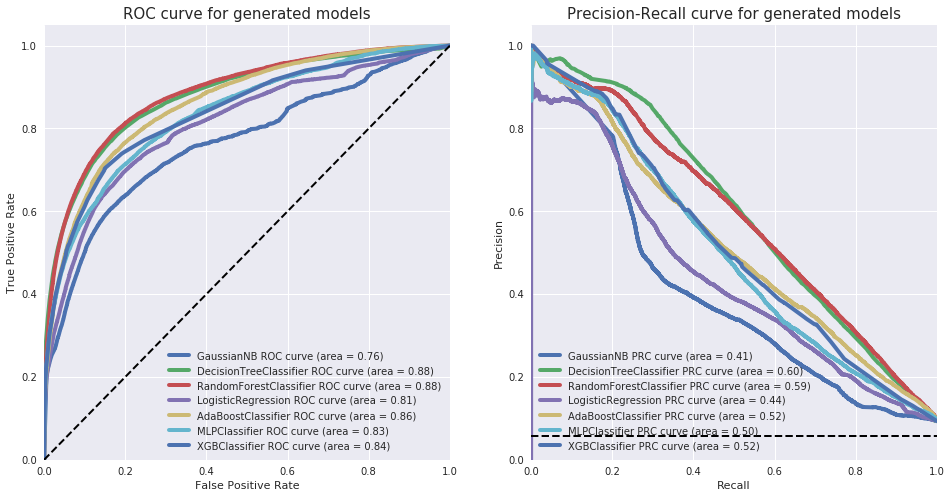

CPU times: user 1h 25min 41s, sys: 5min 30s, total: 1h 31min 12s
Wall time: 5h 7min 41s


In [9]:
%%time
start = time.time()

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, random_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_RdmSearch.log')

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

Model Build Iteration 0
PRE-SAMPLING: (600803, 18) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (1089322, 18) (1089322,) Counter({1: 544661, 0: 544661})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
X_train:  (1089322, 52) (1089322, 1)
X_test:  (257487, 52) (257487, 1)


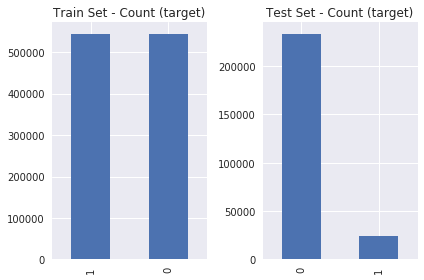

Training NB_random_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_random_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_random_5cv_recall classifier
Optimising using RandomizedSearchCV
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 69.9min


In [ ]:
%%time
start = time.time()

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, random_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_RdmSearch.log')

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
%%time
start = time.time()

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, random_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_RdmSearch.log')

In [ ]:
all_metrics

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, random_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_RdmSearch.log')

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, random_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_RdmSearch.log')

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, random_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_RdmSearch.log')

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
%%time
start = time.time()

sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'gender', 'age_cat', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times','transaction_date_delta']

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, random_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_RdmSearch.log')

### Persist results to disk

In [ ]:
store(all_results, 'Manual_RdmSearch_{0}.pickle'.format(datetime.today().strftime('%Y-%m-%d')))

### Sort the results and get the best sampling config per classifier 

In [ ]:
top_results = all_metrics.sort_values(['balanced_accuracy'], ascending=[False]).groupby('classifier').head(1)
top_results

### Graph the results base on the list of best classifiers above

In [ ]:
temp = filter_top_model_results(top_results, all_results)
plot_roc_prc(temp)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)